In [2]:
import os, sys, glob, tempfile, pickle
import numpy as np
import scipy.linalg as sl, scipy.optimize as so
import matplotlib.pyplot as plt

import libstempo as lt
import numdifftools as nd
import corner
import piccard as pic
from nutstrajectory import nuts6

import interval as itvl

In [3]:
psr = 'J0030+0451'
parfile = glob.glob(f'./{psr}*.par')[0]
timfile = glob.glob(f'./{psr}*.tim')[0]
sfx = ''

In [4]:
likob = itvl.interval(parfile, timfile)

In [5]:
print(likob.full_loglikelihood_grad(likob.pstart))

(64185.19512814801, array([ 4.68499488e+00,  5.29268002e+01,  1.75420071e+02,  4.79566086e+02,
       -5.24764862e+01,  3.64659327e+00,  1.14252733e+01,  2.36851645e+01,
       -1.27918857e+01, -5.35801000e+00,  3.44876596e+00, -4.67188727e+01,
        4.58937533e+01,  1.55144429e+01, -1.82427279e+00, -1.03454812e-01,
       -1.09861220e-01, -1.62200292e-01, -1.82254618e-01, -6.63858018e-02,
       -5.10734876e-02, -2.41380149e-01, -1.52410824e-01, -1.82504585e-01,
        1.25308010e-01, -6.66507072e-02, -1.64595365e-01, -7.10160595e-02,
       -4.86478203e-02, -1.65837292e-01, -6.03458760e-02, -9.52608668e-02,
       -1.52641394e-01, -1.12414282e-01, -9.54034355e-03, -9.48032042e-02,
       -9.76128241e-02, -1.15423494e-01, -2.80705485e-02, -1.78349652e-01,
       -1.12475275e-01, -1.05048370e-01, -2.29600009e-01,  7.48095070e-02,
       -5.46694272e-02, -8.48264722e-02,  4.40277799e-02, -5.50957300e-02,
       -4.62324144e-02, -5.94440511e-02, -4.54853455e-02, -6.13674116e-02,
     

In [6]:
likob.ptaparams

{'J0030+0451_430_ASP_efac': 1.0,
 'J0030+0451_430_PUPPI_efac': 1.0,
 'J0030+0451_L-wide_ASP_efac': 1.0,
 'J0030+0451_L-wide_PUPPI_efac': 1.0,
 'J0030+0451_430_ASP_log10_equad': -6.5,
 'J0030+0451_430_PUPPI_log10_equad': -6.5,
 'J0030+0451_L-wide_ASP_log10_equad': -6.5,
 'J0030+0451_L-wide_PUPPI_log10_equad': -6.5,
 'J0030+0451_basis_ecorr_430_ASP_log10_ecorr': -6.5,
 'J0030+0451_basis_ecorr_430_PUPPI_log10_ecorr': -6.5,
 'J0030+0451_basis_ecorr_L-wide_ASP_log10_ecorr': -6.5,
 'J0030+0451_basis_ecorr_L-wide_PUPPI_log10_ecorr': -6.5,
 'J0030+0451_rn_log10_A': -14.5,
 'J0030+0451_rn_gamma': 3.5100000000000002,
 'J0030+0451_outlierprob': 0.0009999999999999994,
 'timingmodel': 1e-10,
 'fouriermode': 1e-09,
 'jittermode': 1e-09}

In [7]:
def func(x):
    ll, _ = likob.full_loglikelihood_grad(x)
    
    return -np.inf if np.isnan(ll) else ll

def jac(x):
    _, j = likob.full_loglikelihood_grad(x)
    return j

In [8]:
%timeit func(likob.pstart)

139 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
start = likob.pstart

In [10]:
endpfile = psr + '-endp.pickle'

In [11]:
%%time
if not os.path.isfile(endpfile):
    endp = likob.pstart
    for iter in range(3):
        res = so.minimize(lambda x: -func(x),
                          endp,
                          jac=lambda x: -jac(x),
                          hess=None,
                          method='L-BFGS-B', options={'disp': True})

        endp = res['x']
    pickle.dump(endp,open(endpfile,'wb'))
else:
    endp = pickle.load(open(endpfile,'rb'))

CPU times: user 586 µs, sys: 21 µs, total: 607 µs
Wall time: 10.5 ms


In [12]:
func(endp)

64265.52573076887

In [13]:
nhyperpars = likob.ptadict[likob.pname + '_outlierprob'] + 1
print(nhyperpars)

15


In [14]:
hessfile = psr + '-fullhessian.pickle'

In [15]:
%%time
if not os.path.isfile(hessfile):
    reslice = np.arange(0,nhyperpars)

    def partfunc(x):
        p = np.copy(endp)
        p[reslice] = x
        return likob.full_loglikelihood_grad(p)[0]

    ndhessdiag = nd.Hessdiag(func)
    ndparthess = nd.Hessian(partfunc)

    # Create a good-enough approximation for the Hessian
    nhdiag = ndhessdiag(endp)
    nhpart = ndparthess(endp[reslice])
    fullhessian = np.diag(nhdiag)
    fullhessian[:nhyperpars,:nhyperpars] = nhpart
    pickle.dump(fullhessian,open(hessfile,'wb'))
else:
    fullhessian = pickle.load(open(hessfile,'rb'))

CPU times: user 1.67 ms, sys: 60 µs, total: 1.73 ms
Wall time: 84.3 ms


In [16]:
wl = itvl.whitenedLikelihood(likob, endp, -fullhessian)

In [17]:
likob.pstart = endp
wlps = wl.forward(endp)

In [18]:
endp[:20]

array([-1.27090233, -1.32369748, -1.20842529, -1.24767209, -0.14354106,
        0.30414719, -0.19773141, -0.42454599, -0.37549805,  0.18151809,
       -0.38427082, -0.42762086,  0.3869876 ,  0.26810503, -8.39384605,
       -0.08530167, -0.05089194, -0.09609636,  0.01260822, -0.05302287])

In [19]:
print(likob.full_loglikelihood_grad(endp))
print(wl.likob.full_loglikelihood_grad(wl.backward(wlps)))

(64265.52573076887, array([ 1.17482632e-02,  3.03817727e-02,  9.75023420e-02, -1.20560433e-02,
        5.65385722e-02, -1.10725019e-02, -1.75686070e-02,  3.82132717e-02,
       -1.18553159e-02, -3.05907338e-02, -3.15967120e-02, -2.91581910e-02,
        2.41429102e-02,  2.42754079e-02,  6.04126206e-03, -1.15538329e-02,
       -7.28728888e-03, -8.23217552e-03,  2.39434730e-03, -8.71163979e-03,
        3.98727016e-03, -2.84377195e-03, -5.56719286e-03, -5.06760581e-03,
       -1.07998522e-02,  1.70068022e-03, -5.79078908e-05, -1.23203801e-03,
        2.25991100e-04,  1.33791939e-03,  3.54960134e-04,  1.51518214e-03,
       -2.23639265e-03,  3.94076971e-04,  1.93073444e-03,  1.11478403e-03,
        6.92995293e-04, -4.37691898e-06,  1.63198861e-03, -8.54365448e-04,
        1.70948538e-04,  9.95603130e-05, -2.22215938e-03,  7.38557302e-03,
        2.63750219e-03,  1.62436746e-03, -1.96749729e-02,  5.02904697e-04,
       -5.08455055e-04, -8.70428117e-05,  5.58933582e-04,  1.14961010e-03,
     

In [20]:
chaindir = 'chains_' + psr

In [21]:
!mkdir -p {chaindir}

In [22]:
%%time
chainfile = chaindir + '/samples.txt'
if not os.path.isfile(chainfile) or len(open(chainfile,'r').readlines()) < 19999:
    # Run NUTS for 20000 samples, with a burn-in of 1000 samples (target acceptance = 0.6)
    samples, lnprob, epsilon = nuts6(wl.logposterior_grad,20000,1000,
                                     wlps,0.6,
                                     verbose=True,
                                     outFile=chainfile,
                                     pickleFile=chaindir + '/save')

Finished 100.00 percent in 11645.368168 s  epsilon = 2.658538e-01CPU times: user 10h 1min 24s, sys: 37.6 s, total: 10h 2min 1s
Wall time: 3h 14min 14s


In [23]:
parsfile = psr + '-pars.npy'

In [24]:
%%time
if not os.path.isfile(parsfile):
    samples = np.loadtxt(chaindir + '/samples.txt')
    fullsamp = wl.backward(samples[:,:-2])
    funnelsamp = likob.backward(fullsamp)
    pars = likob.multi_full_backward(funnelsamp)
    np.save(parsfile,pars)
else:
    pars = np.load(parsfile)

CPU times: user 1h 51min 3s, sys: 4.1 s, total: 1h 51min 7s
Wall time: 30min 15s


In [25]:
pars.shape

(19999, 447)

In [26]:
print(pars[0])
print(pars[1])
parnames = list(likob.ptadict.keys())

[ 1.15450205e+00  1.08755546e+00  1.17522876e+00  1.12311184e+00
 -8.44950350e+00 -6.39904236e+00 -8.39363564e+00 -9.44420682e+00
 -8.11832222e+00 -7.98099950e+00 -7.93047003e+00 -9.00897703e+00
 -1.36811265e+01  2.72922454e+00  2.05837884e-04 -3.72041678e-05
  8.47695167e-05  4.41277607e-06  6.16814362e-06  6.35265725e-06
  5.87157704e-05 -6.78421767e-06 -4.60702841e-06  3.88149904e-07
  8.58636067e-06  7.75537607e-06 -5.10318275e-07  6.21545954e-06
  6.43668336e-06  6.42227463e-06  3.69270097e-06  2.65984041e-06
  8.50793874e-06  6.68808473e-06  7.76222099e-06  1.90052594e-06
  6.79814713e-06 -5.94088413e-06  3.32514836e-06  1.12771222e-05
  6.61680363e-06  6.44371844e-06  4.61390256e-06  5.25828006e-06
  4.13704242e-06  6.85633338e-06  4.06293074e-06  3.39471105e-06
  8.48572327e-06  4.48923710e-06  5.42582115e-06  4.95737218e-06
 -3.88955123e-06  4.66154932e-06  1.14640069e-05  3.62154046e-06
  6.29749253e-06  6.76607080e-06  6.99874955e-06  3.07832244e-06
 -2.03220758e-06  3.84578

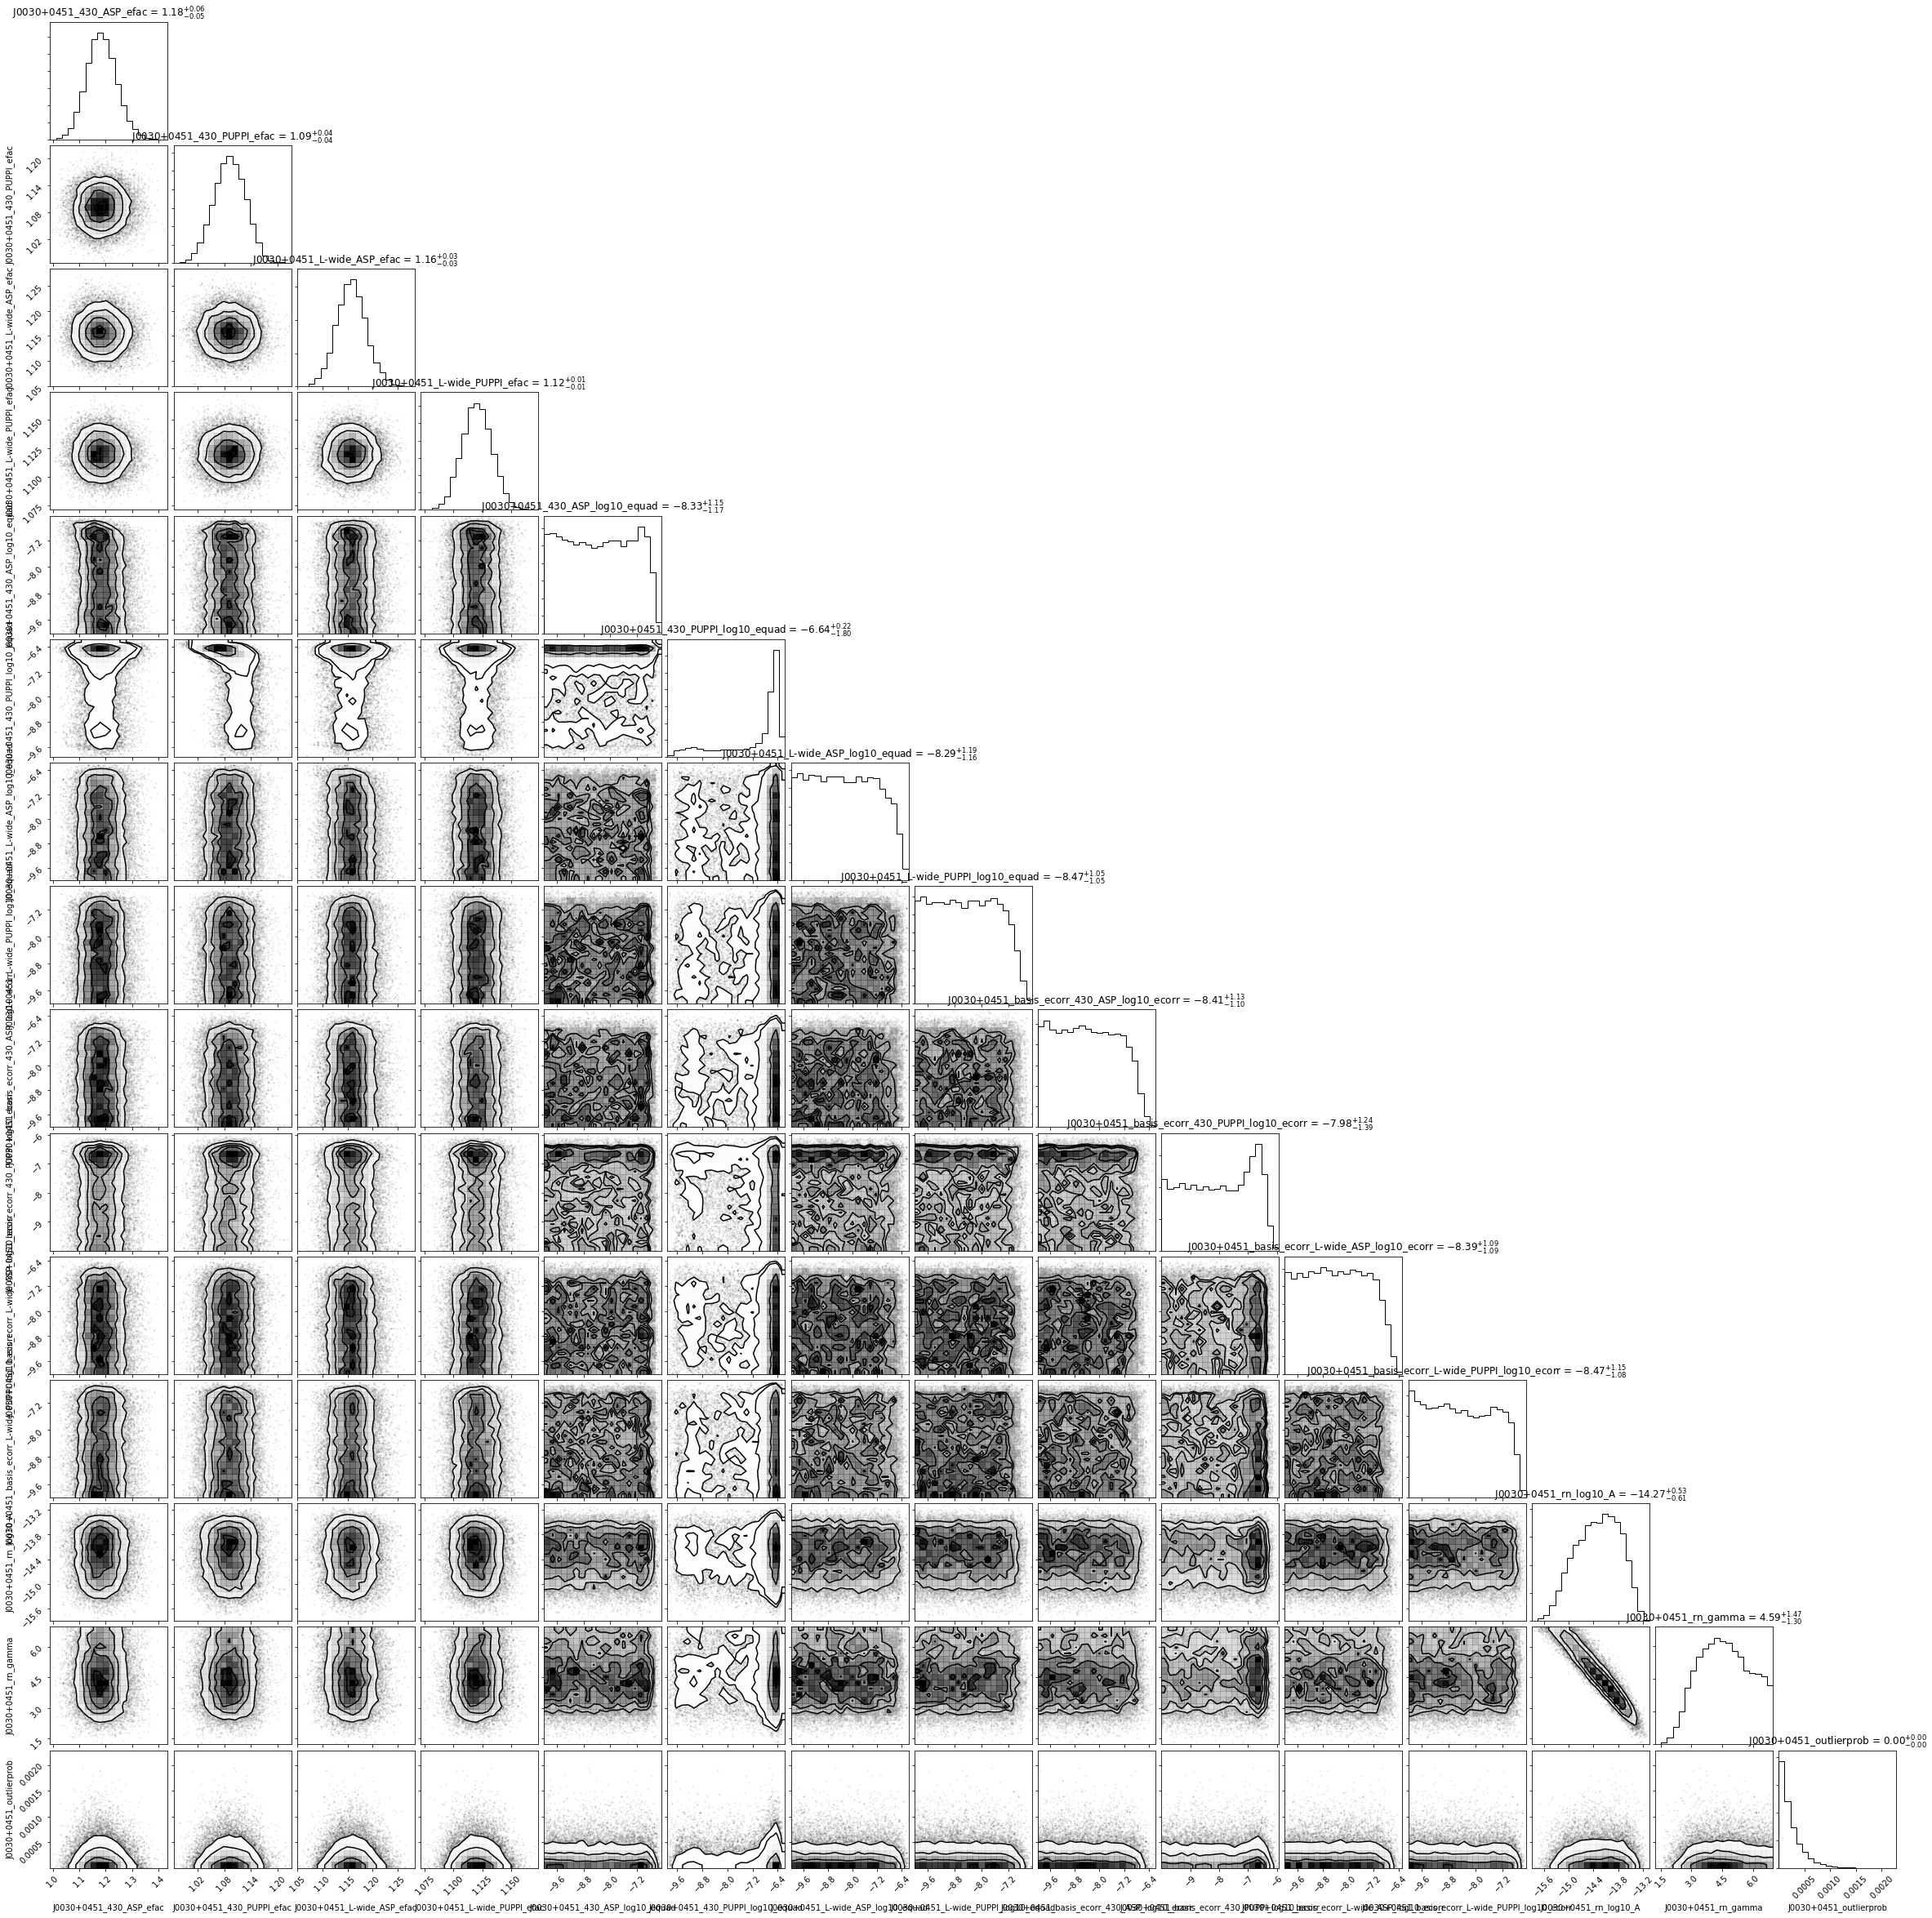

In [27]:
if not os.path.isfile(psr + '-corner.pdf'):
    corner.corner(pars[:,:nhyperpars],labels=parnames[:nhyperpars],show_titles=True);
    plt.savefig(psr + '-corner.pdf')

In [28]:
likob.P0

0.0048654532112551223496

In [29]:
def poutlier(p,likob):
    """Invoked on a sample parameter set and the appropriate likelihood,
    returns the outlier probability (a vector over the TOAs) and
    the individual sqrt(chisq) values"""
    
    # invoke the likelihood
    _, _ = likob.base_loglikelihood_grad(p)

    # get the piccard pulsar object
    # psr = likob.psr

    r = likob.detresiduals
    N = likob.Nvec

    Pb = likob.outlier_prob # a priori outlier probability for this sample
    P0 = likob.P0           # width of outlier range
    
    PA = 1.0 - Pb
    PB = Pb
    
    PtA = np.exp(-0.5*r**2/N) / np.sqrt(2*np.pi*N)
    PtB = 1.0/P0
    
    num = PtB * PB
    den = PtB * PB + PtA * PA
    
    return num/den, r/np.sqrt(N)

In [30]:
pobsfile = psr + '-pobs.npy'

In [31]:
%%time
if not os.path.isfile(pobsfile):
    nsamples = len(pars)
    nobs = len(likob.Nvec)

    # basic likelihood
    lo = likob

    outps = np.zeros((nsamples,nobs),'d')
    sigma = np.zeros((nsamples,nobs),'d')

    for i,p in enumerate(pars):
        outps[i,:], sigma[i,:] = poutlier(p,lo)

    out = np.zeros((nsamples,nobs,2),'d')
    out[:,:,0], out[:,:,1] = outps, sigma    
    np.save(pobsfile,out)
else:
    out = np.load(pobsfile)
    outps, sigma = out[:,:,0], out[:,:,1]

CPU times: user 7min 16s, sys: 2.55 s, total: 7min 19s
Wall time: 7min 3s


In [32]:
if 'outno' not in sfx:
    avgps = np.mean(outps,axis=0)
    medps = np.median(outps,axis=0)

Big: 0
Plotted: 9


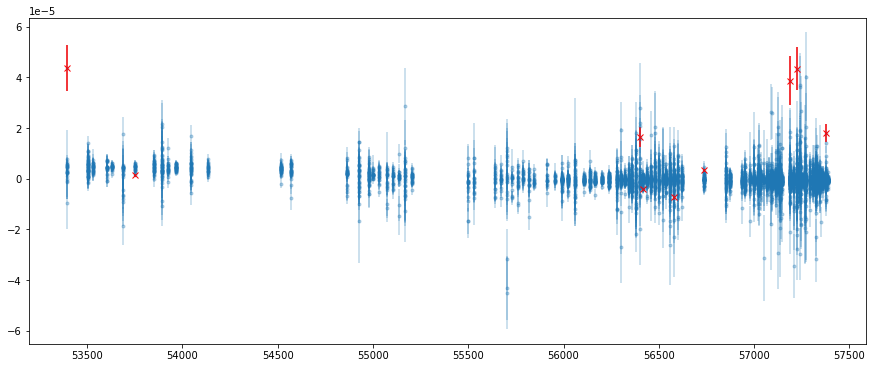

In [33]:
residualplot = psr + '-residuals.pdf'

if 'outno' not in sfx and not os.path.isfile(residualplot):
    outliers = medps > 0.1
    nout = np.sum(outliers)
    nbig = nout
    
    print("Big: {}".format(nbig))
    
    if nout == 0:
        outliers = medps > 5e-4
        nout = np.sum(outliers)
    
    print("Plotted: {}".format(nout))

    plt.figure(figsize=(15,6))

    psrobj = likob.psr

    # convert toas to mjds
    toas = psrobj.toas/pic.pic_spd + pic.pic_T0

    # red noise at the starting fit point
    _, _ = likob.full_loglikelihood_grad(endp)
    rednoise = psrobj.residuals - likob.detresiduals

    # plot tim-file residuals (I think)
    plt.errorbar(toas,psrobj.residuals,yerr=psrobj.toaerrs,fmt='.',alpha=0.3)

    # red noise
    # plt.plot(toas,rednoise,'r-')

    # possible outliers
    plt.errorbar(toas[outliers],psrobj.residuals[outliers],yerr=psrobj.toaerrs[outliers],fmt='rx')

    plt.savefig(residualplot)

In [34]:
for ii, elem in enumerate(outliers):
    if elem:
        print(f'Outlier TOA index: {ii}')
        print(f'Outlier probability: {medps[ii]}')

Outlier TOA index: 9
Outlier probability: 0.0007278079021376674
Outlier TOA index: 215
Outlier probability: 0.0021328137535970093
Outlier TOA index: 1868
Outlier probability: 0.0008704511132286973
Outlier TOA index: 1884
Outlier probability: 0.0008811365175870755
Outlier TOA index: 2469
Outlier probability: 0.05982381569536181
Outlier TOA index: 2697
Outlier probability: 0.02496503173134417
Outlier TOA index: 4059
Outlier probability: 0.0005701187522735339
Outlier TOA index: 4308
Outlier probability: 0.035146877015749756
Outlier TOA index: 5545
Outlier probability: 0.04312528655828564
